Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2461679..9.288399].


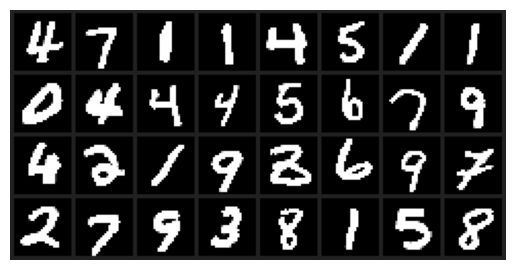

tensor([4, 7, 1, 1, 4, 5, 1, 1, 0, 4, 4, 4, 5, 6, 7, 9, 4, 2, 1, 9, 3, 6, 9, 7,
        2, 7, 9, 3, 8, 1, 5, 8])
Epoch 1/20 - Step: 99/1875 - Loss: 2.2966
Epoch 1/20 - Step: 199/1875 - Loss: 2.2933
Epoch 1/20 - Step: 299/1875 - Loss: 2.2866
Epoch 1/20 - Step: 399/1875 - Loss: 2.2750
Epoch 1/20 - Step: 499/1875 - Loss: 2.2491
Epoch 1/20 - Step: 599/1875 - Loss: 2.1737
Epoch 1/20 - Step: 699/1875 - Loss: 2.0525
Epoch 1/20 - Step: 799/1875 - Loss: 1.9301
Epoch 1/20 - Step: 899/1875 - Loss: 1.8202
Epoch 1/20 - Step: 999/1875 - Loss: 1.7131
Epoch 1/20 - Step: 1099/1875 - Loss: 1.6176
Epoch 1/20 - Step: 1199/1875 - Loss: 1.5280
Epoch 1/20 - Step: 1299/1875 - Loss: 1.4489
Epoch 1/20 - Step: 1399/1875 - Loss: 1.3738
Epoch 1/20 - Step: 1499/1875 - Loss: 1.3089
Epoch 1/20 - Step: 1599/1875 - Loss: 1.2518
Epoch 1/20 - Step: 1699/1875 - Loss: 1.1991
Epoch 1/20 - Step: 1799/1875 - Loss: 1.1503
Epoch 1 - Accuracy: 0.9489 - Validation Loss : 0.1735
Epoch 2/20 - Step: 99/1875 - Loss: 0.2805
Epoch 2/20

In [11]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch import nn, optim
from torchvision import datasets, transforms

batch_size = 32             # Lượng ảnh sẽ dùng trong 1 lô.
learning_rate = 0.01        # Learning Rate sẽ dùng với optimizer.
num_epochs = 20             # Số lần sử dụng toàn bộ dữ liệu để train.

# Load data MNIST 
# (0.1307, ) là giá trị trung bình (mean) của các kênh màu của hình ảnh. (Do ảnh xám nên có duy nhất 1 kênh màu)
# (0.3081, ) là độ lệch chuẩn (std) của các kênh màu của hình ảnh. (Do ảnh xám nên có duy nhất 1 kênh màu)
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST("./data", train=True, download=True,
                       transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307, ), (0.3081, )), # Chuẩn hóa dữ liệu
                               ])),
        batch_size=batch_size, 
        shuffle=True)

val_loader = torch.utils.data.DataLoader(
        datasets.MNIST("./data", train=False, download=True,
                       transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307, ), (0.3081, )), # Chuẩn hóa dữ liệu
                               ])),
        batch_size=batch_size, 
        shuffle=False)

# Visualize Data
def imshow(img, mean, std):
    img = img / std + mean 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images), 0.1307, 0.3081)
print(labels)

# Xây dựng một mô hình CNN với nhiều lớp convolution và fully connected
class BetterModel(nn.Module):
    def __init__(self, num_classes=10):
        super(BetterModel, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 3 * 3)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

# Get Device 
# Lựa chọn GPU hoặc CPU tùy theo máy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model 
# Chuyển model vào GPU nếu có
model = BetterModel().to(device)

# Loss function 
# PyTorch chủ động tính loss bằng Log Softmax và Negative Log Likelihood loss
criterion = nn.CrossEntropyLoss()

# Optimizer 
# Có sẵn trong package optim của PyTorch
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

num_steps = len(train_loader)

for epoch in range(num_epochs):
    
    # ---------- TRAINING ----------
    # set model to training
    model.train()    
    
    total_loss = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward
        outputs = model(images)
        
        # Compute Loss
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        total_loss += loss.item()        
                
        # Print Log
        if (i + 1) % 100 == 0:
            print("Epoch {}/{} - Step: {}/{} - Loss: {:.4f}".format(
                    epoch + 1, num_epochs, i, num_steps, total_loss / (i + 1)))

    # ---------- VALIDATION ----------
    # set model to evaluating
    model.eval()
    
    val_losses = 0

    with torch.no_grad():
        correct = 0
        total = 0
        for _, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs, 1)
            
            loss = criterion(outputs, labels)
            
            val_losses += loss.item()
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        print("Epoch {} - Accuracy: {} - Validation Loss : {:.4f}".format(
                epoch + 1, 
                correct / total,
                val_losses / (len(val_loader))))

file_path='mnist_model.pth'
torch.save(model.state_dict(), file_path)
print(f'Model saved to {file_path}')


In [12]:
# Init model
model = BetterModel()

model.load_state_dict(torch.load('mnist_model.pth'))
model.eval()

# Create dummy_input với cùng kích thước đầu vào của mô hình
dummy_input = torch.randn(1, 1, 28, 28)  # batch_size=1, 1 channel (grayscale), 28x28 image

# Chuyển đổi sang ONNX
torch.onnx.export(model, dummy_input, "mnist_model.onnx", 
                  input_names=['input'], output_names=['output'], 
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})

print("Model đã được chuyển đổi sang ONNX và lưu tại mnist_model.onnx")


C:\Users\HP\AppData\Local\Temp\ipykernel_18032\1907363015.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mnist_model.pth'))


Model đã được chuyển đổi sang ONNX và lưu tại mnist_model.onnx


In [16]:
import onnxruntime as ort
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

# Load Model ONNX
onnx_model_path = "mnist_model.onnx"
ort_session = ort.InferenceSession(onnx_model_path)

# Preprocessing Input 
def preprocess(image_path):
    transform = transforms.Compose([transforms.Grayscale(), 
                                    transforms.Resize((28, 28)), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.1307,), (0.3081,))])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Thêm batch dimension
    return image.numpy()

# AI Inference
def infer(image_path):
    input_data = preprocess(image_path)
    outputs = ort_session.run(None, {'input': input_data})
    predicted_class = np.argmax(outputs[0]) # Trả về chỉ số của lớp max_val trong mảng (tức xác suất cao nhất)
    print(f"Predicted class: {predicted_class}")

# Experiment
infer("content/siz.png")


Predicted class: 6
